# Process data

In [8]:
import csv
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [9]:
file_path="diabetes.csv"
# Read the CSV file
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    header = next(reader)  # Skip the header row
    data = []
    for row in reader:
        data.append([float(value) for value in row])

# Convert to numpy array for easier manipulation
data = np.array(data)

In [10]:
# Columns to replace zero values
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
columns_indices = [header.index(col) for col in columns_to_replace]

for col_idx in columns_indices:
    col_values = data[:, col_idx]
    non_zero_values = col_values[col_values != 0]
    mean_value = np.mean(non_zero_values)
    col_values[col_values == 0] = mean_value
    data[:, col_idx] = col_values

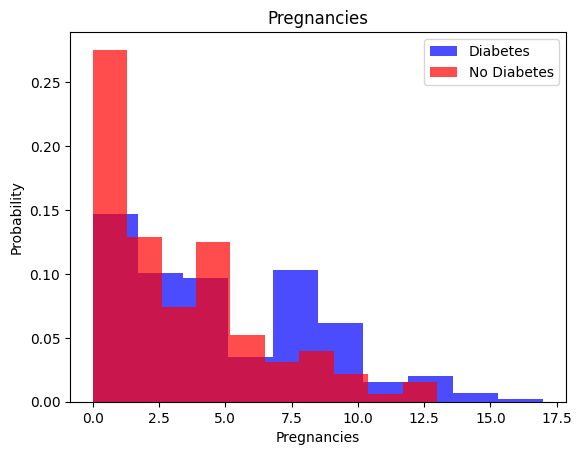

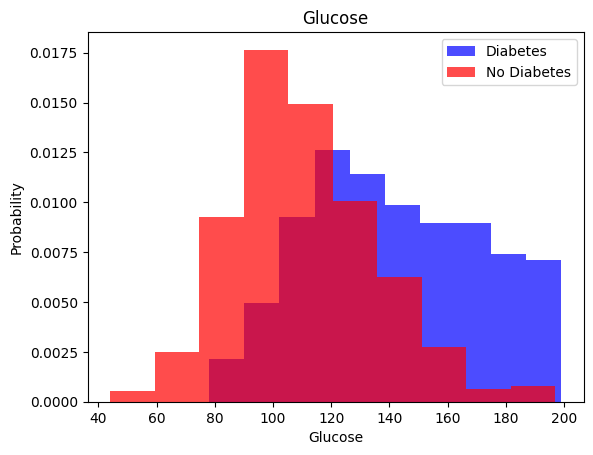

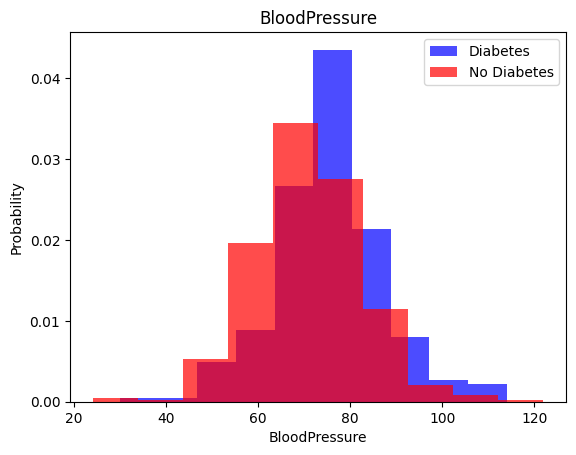

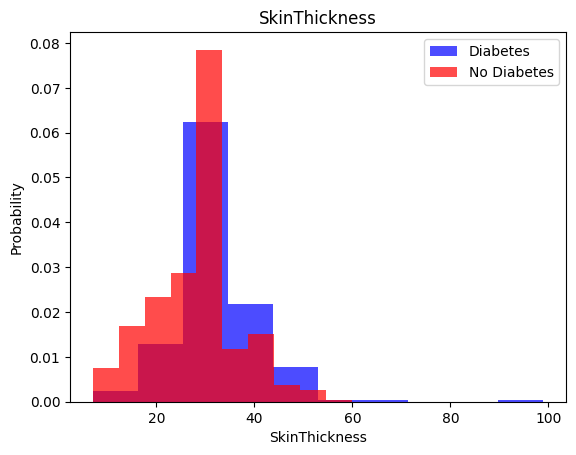

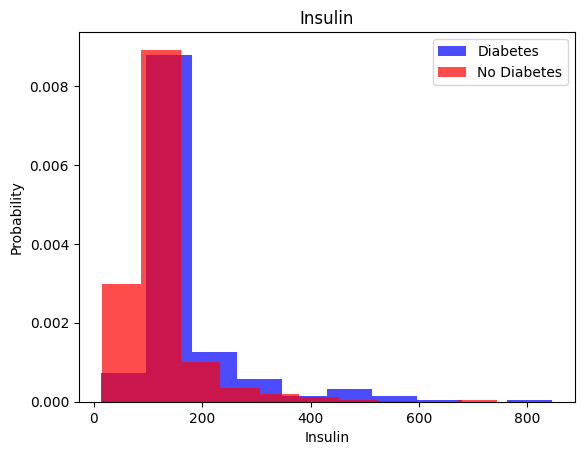

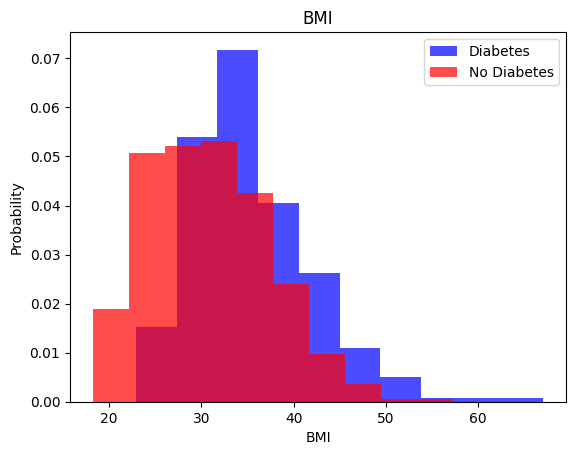

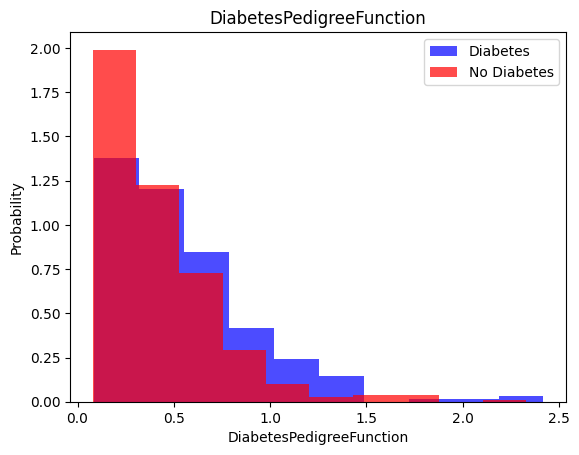

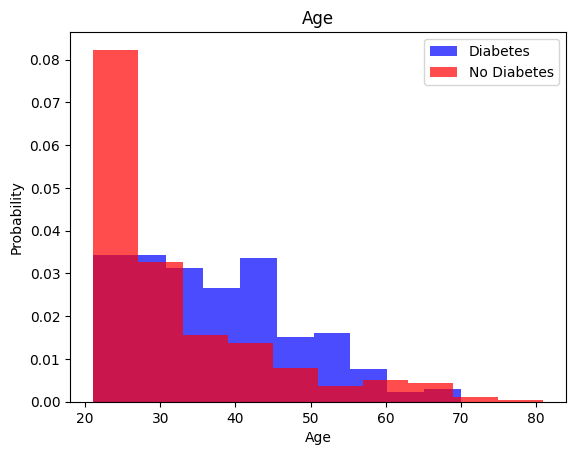

In [4]:
# Probability of having diabetes per feature
for label in header[:-1]:
    plt.hist(data[data[:, -1] == 1][:, header.index(label)], color='blue', label='Diabetes', alpha=0.7, density=True)
    plt.hist(data[data[:, -1] == 0][:, header.index(label)], color='red', label='No Diabetes', alpha=0.7, density=True)
    plt.title(label)
    plt.ylabel("Probability")
    plt.xlabel(label)
    plt.legend()
    plt.show()

In [5]:
np.random.shuffle(data)

# Split into train (60%), validation (20%), and test (20%) sets
train_idx = int(0.6 * len(data))
valid_idx = int(0.8 * len(data))

train = data[:train_idx]
valid = data[train_idx:valid_idx]
test = data[valid_idx:]

In [6]:
def scale_dataset(dataframe, oversample=False):
    X = dataframe[:, :-1]  # Extract features (all columns except the last)
    y = dataframe[:, -1]   # Extract labels (last column)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, y.reshape(-1, 1)))  # Concatenate X and y back together

    return data, X, y

In [7]:
train, X_train, y_train=scale_dataset(train,oversample=True)
valid, X_valid, y_valid=scale_dataset(valid)
test, X_test, y_test=scale_dataset(test)

# Random Forest

In [15]:
def train_rf_model(X_train, y_train, X_valid, y_valid, params):
    """
    Train Random Forest models with different hyperparameters and visualize accuracy and loss.

    Parameters:
    - X_train, y_train: Training data and labels
    - X_valid, y_valid: Validation data and labels
    - params: Dictionary of lists containing different values to try for each parameter

    Returns:
    - best_model: Trained Random Forest model with the lowest validation loss
    """
    rf_val_acc= -float('inf')
    best_model = None
    accuracies = []
    best_params_rf=None

    for n_estimators in params['n_estimators']:
        for max_depth in params['max_depth']:
            for min_samples_split in params['min_samples_split']:
                for min_samples_leaf in params['min_samples_leaf']:
                    # Create Random Forest classifier
                    rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                                      max_depth=max_depth,
                                                      min_samples_split=min_samples_split,
                                                      min_samples_leaf=min_samples_leaf,
                                                      random_state=42)

                    # Train the model
                    rf_model.fit(X_train, y_train)

                    # Evaluate on validation set
                    val_accuracy = rf_model.score(X_valid, y_valid)
                    accuracies.append(val_accuracy)

                    # Track the best model based on validation accuracy
                    if val_accuracy > rf_val_acc:
                        rf_val_acc = val_accuracy
                        best_model = rf_model
                        best_params_rf = {'n_estimators': n_estimators,'max_depth': max_depth,'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf}
    return best_model, rf_val_acc,best_params_rf

In [16]:
# Define parameter ranges to try
params = {
    'n_estimators': [10,25,50, 100, 125,150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4,8, 10],
    'min_samples_leaf': [1, 2, 4,8]
}

# Train Random Forest models with different parameters & get the most accurate one
best_rf_model, rf_accuracy,best_params = train_rf_model(X_train, y_train, X_valid, y_valid, params)


print(f'Random Forest Test Accuracy: {rf_accuracy}')
print(f'Best Params: {best_params}')

Random Forest Test Accuracy: 0.8181818181818182
Best Params: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 4}


In [17]:
print("\nRandom Forest Classification Report:")
y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.76      0.83       105
         1.0       0.63      0.86      0.72        49

    accuracy                           0.79       154
   macro avg       0.77      0.81      0.78       154
weighted avg       0.83      0.79      0.80       154



# Logistic Regression


In [33]:
def train_lg_model(X_train, y_train, X_valid, y_valid, params):
    """
    Train Logistic Regression models with different hyperparameters and select the one with the highest accuracy.

    Parameters:
    - X_train, y_train: Training data and labels
    - X_valid, y_valid: Validation data and labels
    - params: Dictionary of lists containing different values to try for each parameter

    Returns:
    - best_model: Trained Logistic Regression model with the highest accuracy
    - best_accuracy: Highest accuracy achieved on the validation set
    - best_params: Best parameters configuration that achieved the highest accuracy
    """
    best_accuracy = 0.0
    best_model = None
    best_params = None

    for penalty in params['penalty']:
        for C in params['C']:
            for solver in params['solver']:
                # Create Logistic Regression classifier
                lg_model = LogisticRegression(penalty=penalty, C=C, solver=solver, random_state=42)

                # Train the model
                lg_model.fit(X_train, y_train)

                # Evaluate on validation set
                val_accuracy = lg_model.score(X_valid, y_valid)

                # Track the best model based on validation accuracy
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_model = lg_model
                    best_params = {'penalty': penalty, 'C': C, 'solver': solver}

    return best_model, best_accuracy, best_params

In [37]:
# Define parameter ranges to try
lg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

# Train Logistic Regression models with different parameters & get the most accurate one
best_lg_model, lg_accuracy, best_lg_params = train_lg_model(X_train, y_train, X_valid, y_valid, lg_params)
print(f'Logistic Regression Validation Accuracy: {lg_accuracy}')
print(f'Best Parameters: {best_lg_params}')

Logistic Regression Validation Accuracy: 0.7662337662337663
Best Parameters: {'penalty': 'l1', 'C': 0.1, 'solver': 'saga'}


In [38]:
y_pred=best_lg_model.predict(X_test)

In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88       105
         1.0       0.71      0.82      0.76        49

    accuracy                           0.84       154
   macro avg       0.81      0.83      0.82       154
weighted avg       0.85      0.84      0.84       154

